## domain-wall TSP

In [318]:
import numpy as np
    
def gen_random_tsp(num_cities: int):
    rng = np.random.default_rng()
    
    # 座標
    locations = rng.random(size=(num_cities, 2))
    
    # 距離行列
    x = locations[:, 0]
    y = locations[:, 1]
    distances = np.sqrt(
        (x[:, np.newaxis] - x[np.newaxis, :]) ** 2
        + (y[:, np.newaxis] - y[np.newaxis, :]) ** 2
    )
    
    return locations, distances

NUM_CITIES = 20
locations, distances = gen_random_tsp(NUM_CITIES)

# print(distances)

In [134]:
import matplotlib.pyplot as plt
    
def show_plot(locations: np.ndarray):
    plt.figure(figsize=(7, 7))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(locations[:, 0], locations[:, 1])
    plt.show()

def show_route(route: np.ndarray, distances: np.ndarray, locations: np.ndarray):
    path_length = sum([distances[route[i]][route[(i + 1) % NUM_CITIES]] for i in range(NUM_CITIES-1)])
    
    x = [i[0] for i in locations]
    y = [i[1] for i in locations]
    plt.figure(figsize=(7, 7))
    plt.title(f"path length: {path_length}")
    plt.xlabel("x")
    plt.ylabel("y")
    
    for i in range(NUM_CITIES):
        r = route[i]
        n = route[(i + 1) % NUM_CITIES]
        plt.plot([x[r], x[n]], [y[r], y[n]], "b-")
    plt.plot(x, y, "ro")
    plt.show()
    
    # return path_length

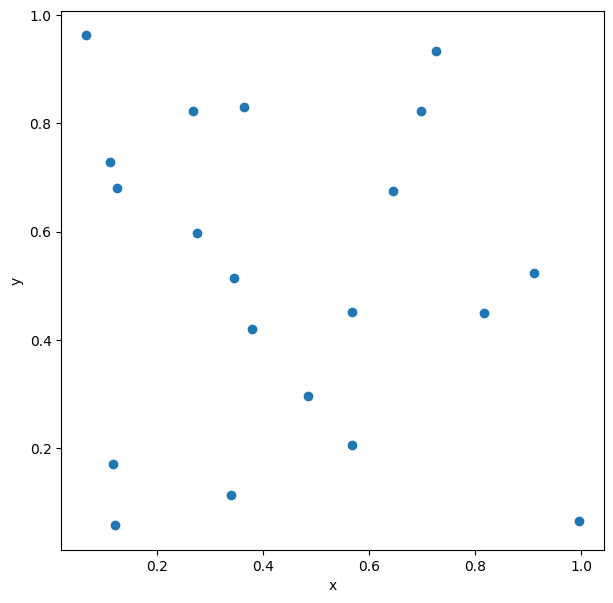

In [319]:
show_plot(locations)

In [320]:
from amplify import VariableGenerator

gen = VariableGenerator()
q = gen.array("Binary", shape=(NUM_CITIES, NUM_CITIES+1))
# x[i,a]: i番目に都市aを訪問する。x[i,a] = b[i,a] - b[i,a+1]

q[:,0] = 1; q[:,NUM_CITIES] = 0

# print(q)

In [348]:
# domain wall 制約
chain = 0
for i in range(NUM_CITIES):
    for a in range(NUM_CITIES):
        chain -= 1 - 2*q[i,a] - 2*q[i,a+1] + 4*q[i,a]*q[i,a+1]

# 制約関数
const = 0
for i in range(NUM_CITIES):
    for j in range(NUM_CITIES):
        for a in range(NUM_CITIES):
            const += (q[i,a] - q[i,a+1])*(q[j,a] - q[j,a+1])

# コスト関数
cost = 0
for i in range(NUM_CITIES-1):
    for a in range(NUM_CITIES):
        for b in range(NUM_CITIES):
            cost += distances[a,b] * (q[i,a] - q[i,a+1]) * (q[i+1,b] - q[i+1,b+1])

model = cost + chain * np.amax(distances)*(const)

イジングマシン実行

In [351]:
from datetime import timedelta
from amplify import FixstarsClient, solve
from datetime import timedelta
    
    
client = FixstarsClient()
client.token = "AE/uoJdkjxByNhoLWqMYIpjf2uIl2SUOi8m"  
client.parameters.timeout = timedelta(milliseconds=1000)  # タイムアウト 1000 ミリ秒
    
# ソルバーの設定と結果の取得
result = solve(model, client)
if len(result) == 0:
    raise RuntimeError("At least one of the constraints is not satisfied.")

print(result.best.objective)

RuntimeError: 400: Bad Request, The problem size for sparse matrix input exceeds the limit of 16384 for your service plan.

In [346]:
q_values =q.evaluate(result.best.values)
# print(q_values)

# route = np.where(q_values[:] == 1)[1]

# 各行に処理を適用
route = []
for row in q_values:
    changes = np.where(row[:-1] > row[1:])[0]  # 1から0への変化がある場所を見つける
    route.append(int(changes[0]) if changes.size > 0 else 0)  # 最初の変化を返す

print(route)

[13, 19, 12, 7, 4, 8, 9, 6, 17, 2, 14, 16, 18, 15, 11, 0, 3, 1, 5, 10]


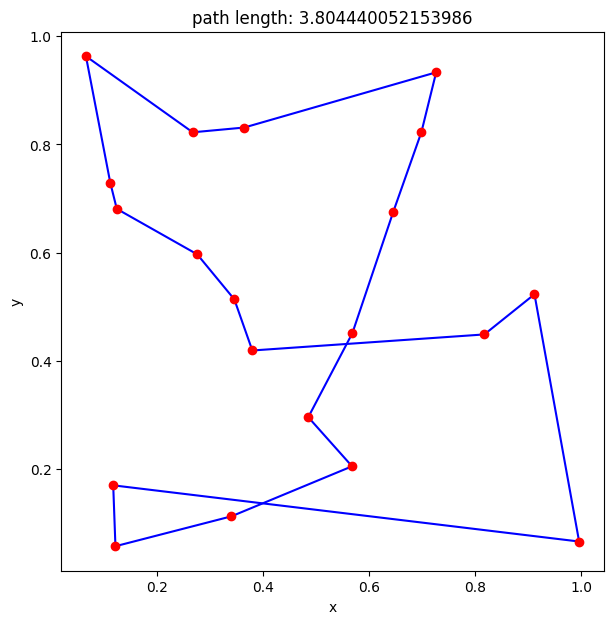

In [347]:
show_route(route, distances, locations)